# Steel Defect Detection - EDA 02

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from PIL import ImageDraw
import cv2

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils

In [5]:
IMAGE_FOLDER = os.path.join(config.DATA_FOLDER, 'train_images')
TRAIN_CSV = os.path.join(config.DATA_FOLDER, 'train_with_bboxes.csv')

In [ ]:
#dfdefect = pd.read_csv(os.path.join(config.DATA_FOLDER, 'train.csv'))

In [6]:
df = pd.read_csv(TRAIN_CSV)

In [13]:
def rle_decode(rle, height=1600, width=256):
    mask = np.zeros(height * width, dtype=np.uint8)
    rle = list(map(int, rle.split()))
    for start, length in zip(rle[0::2], rle[1::2]):
        start -= 1
        mask[start:start+length] = 1
    return mask.reshape((height, width))

def rle_to_bboxes(rle, H=1600, W=256):
    mask = rle_decode(rle, H, W)

    # connected component labels
    num_labels, labels = cv2.connectedComponents(mask)

    bboxes = []
    for label in range(1, num_labels):
        ys, xs = np.where(labels == label)
        if len(xs) == 0:
            continue
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes

In [15]:
# generate bounding boxes list
idx = 0
list_data = []
for idx, row in df.iterrows():
    rle = row['EncodedPixels']
    image_id = row['ImageId']
    bboxes_list = []
    if pd.isna(rle):
        bboxes_list.append([])
    else:
        bboxes = rle_to_bboxes(rle)
        bboxes_list.append(bboxes)
    data = {
        'ImageId': image_id,
        'bboxes': bboxes
    }
    list_data.append(data)
    
    idx = idx + 1

In [18]:
# convert to df
bboxes_df = pd.DataFrame(list_data)

# merge with original df
df = df.merge(bboxes_df, on='ImageId', how='left')

In [19]:
df.head(10)

,ImageId,ClassId,EncodedPixels,IsDefect,DefectArea,bboxes
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,4396,"[[161, 113, 184, 127], [88, 304, 193, 331], [1..."
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1,6897,"[[146, 72, 255, 85], [4, 1145, 254, 1167]]"
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1,8319,"[[206, 146, 241, 187], [202, 244, 224, 267], [..."
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1,69357,"[[0, 515, 217, 860], [126, 853, 255, 1131]]"
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1,4851,"[[60, 896, 249, 929]]"
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,1,28506,"[[2, 33, 106, 227], [95, 836, 176, 868], [4, 8..."
6,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,1,28506,"[[0, 1231, 47, 1416], [65, 1389, 185, 1512]]"
7,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...,1,17541,"[[2, 33, 106, 227], [95, 836, 176, 868], [4, 8..."
8,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...,1,17541,"[[0, 1231, 47, 1416], [65, 1389, 185, 1512]]"
9,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...,1,5001,"[[222, 1135, 254, 1224], [189, 1382, 254, 1454]]"


In [20]:
sample_non_defect_images = df[df['IsDefect'] == 0].sample(10, random_state=config.SEED)['ImageId'].values

df_sample_defect_images_class_1 = df[(df['IsDefect'] == 1) & (df['ClassId'] == 1)].sample(10)
df_sample_defect_images_class_2 = df[(df['IsDefect'] == 1) & (df['ClassId'] == 2)].sample(10)
df_sample_defect_images_class_3 = df[(df['IsDefect'] == 1) & (df['ClassId'] == 3)].sample(10)
df_sample_defect_images_class_4 = df[(df['IsDefect'] == 1) & (df['ClassId'] == 4)].sample(10)


In [21]:
sample_non_defect_images

array(['29360cd19.jpg', '1395f831c.jpg', 'dd154baf9.jpg', 'ba8a923fa.jpg',
       '034e64ff3.jpg', '7f08f1369.jpg', 'e2c3eb1ff.jpg', 'deb688828.jpg',
       'e4dffa21c.jpg', 'ac2b7af8c.jpg'], dtype=object)

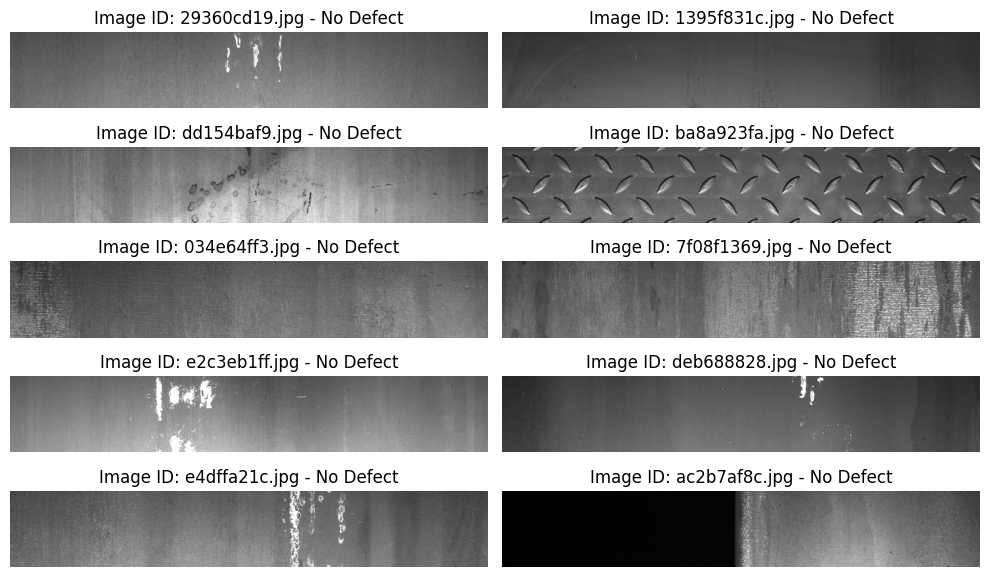

In [22]:
#plot non-defect images, in subplots 5 rows and 2 columns
fig, axs = plt.subplots(5, 2, figsize=(10, 6))
for i, image_id in enumerate(sample_non_defect_images):
    img = Image.open(os.path.expanduser( os.path.join(IMAGE_FOLDER, image_id) ) )
    axs[i//2, i%2].imshow(img)
    axs[i//2, i%2].set_title(f'Image ID: {image_id} - No Defect')
    axs[i//2, i%2].axis('off')
plt.tight_layout()
plt.show()


In [14]:
dfdefect[dfdefect['ImageId'] == '8a642f9d3.jpg']

,ImageId,ClassId,EncodedPixels
3786,8a642f9d3.jpg,1,26081 3 26331 9 26582 14 26832 20 27083 25 273...
3787,8a642f9d3.jpg,3,77382 5 77637 15 77892 21 78148 21 78403 23 78...


In [39]:

def rle_decode2(mask_rle, shape):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape, order='F')


In [50]:
def plot_sample_defect_images(df_sample, classId):
    #plot non-defect images, in subplots 5 rows and 2 columns
    fig, axs = plt.subplots(5, 2, figsize=(12, 8))
    for i, data in enumerate(df_sample.itertuples()):
        image_id = data.ImageId
        rle = data.EncodedPixels
        
        
        # draw mask on img
        mask = Image.new("L", img.size, 0)

        if pd.notnull(rle):
            mask_arr = rle_decode2(rle, img.size[::-1])  # img.size is (width, height)
            mask.paste(Image.fromarray(mask_arr), (0, 0))
            overlay = Image.new("RGBA", img.size, (255,255,0,100))
            overlay.putalpha(mask)
            combined = Image.alpha_composite(img.convert("RGBA"), overlay)
        else:
            combined = img.convert("RGBA")

        axs[i//2, i%2].imshow(combined)
        axs[i//2, i%2].set_title(f'Image ID: {image_id} - Defect Class {classId}')
        axs[i//2, i%2].axis('off')

    plt.tight_layout()
    plt.show()


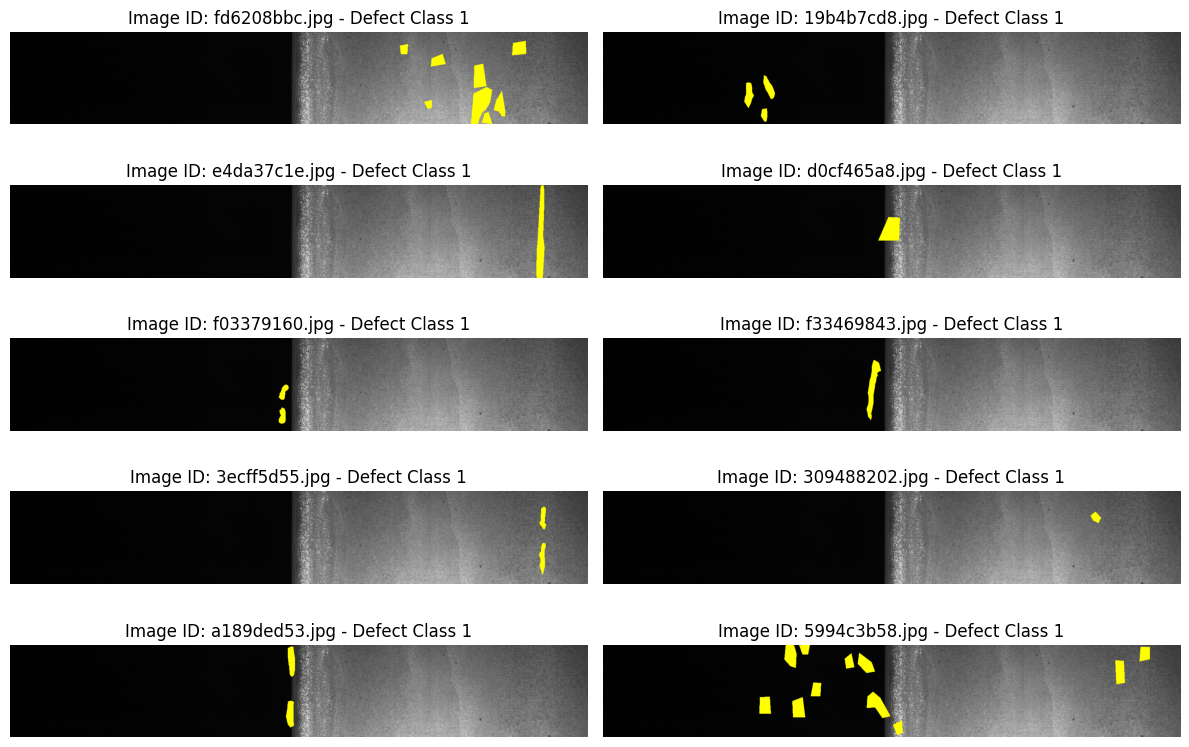

In [51]:
plot_sample_defect_images(df_sample_defect_images_class_1, '1')

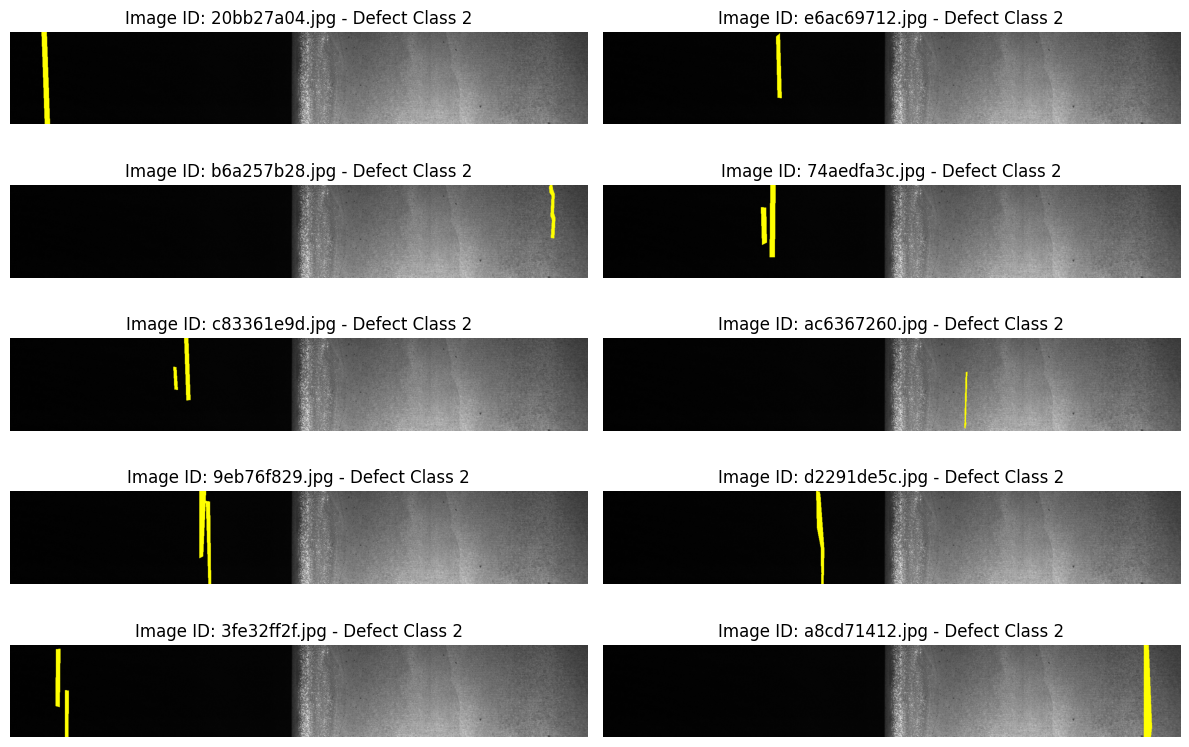

In [52]:
plot_sample_defect_images(df_sample_defect_images_class_2, '2')

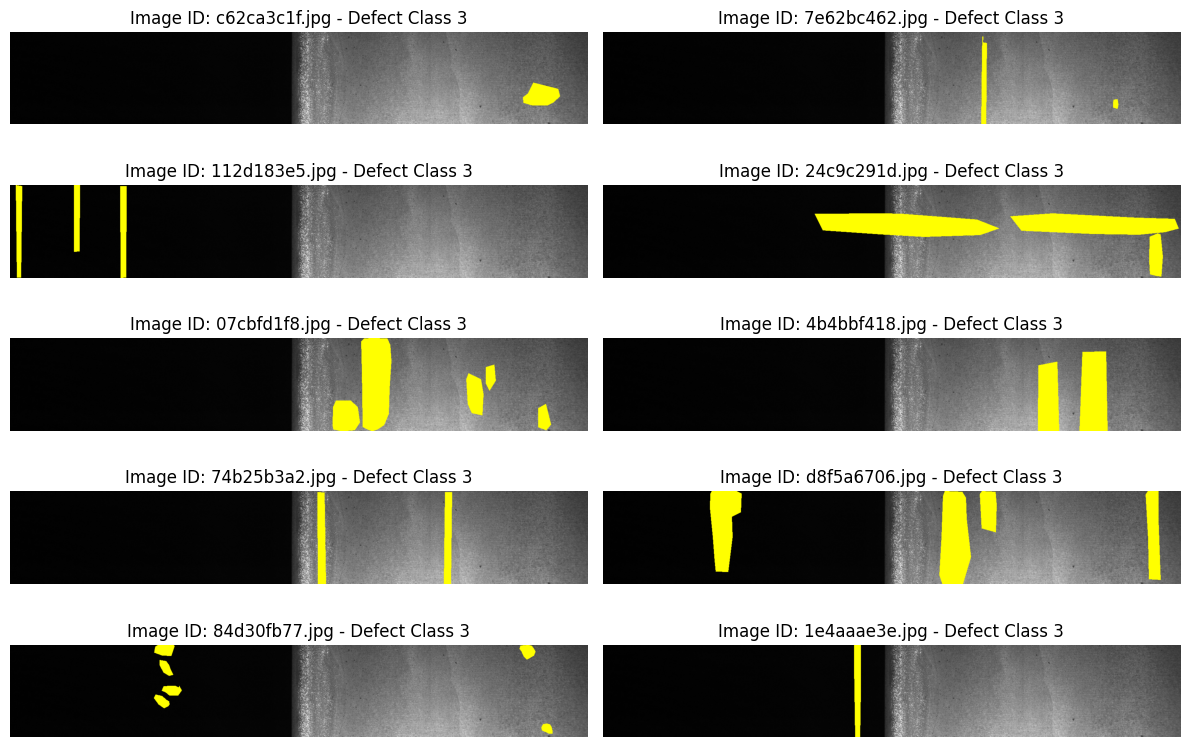

In [53]:
plot_sample_defect_images(df_sample_defect_images_class_3, '3')

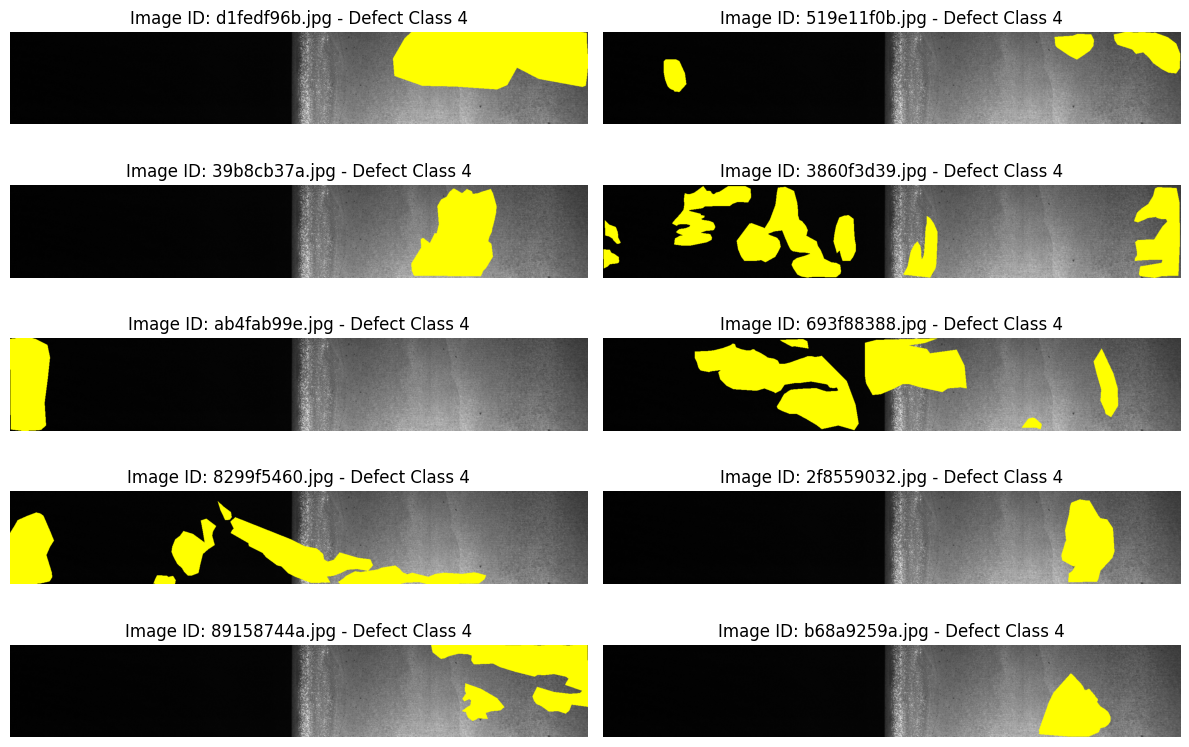

In [54]:
plot_sample_defect_images(df_sample_defect_images_class_4, '4')

In [55]:
from collections import Counter


# show distribution of images resolution

gray = []

hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

means = []
stds = []

global_counter = Counter()

for idx, img_path in enumerate(df['ImageId'].values):
    filename = os.path.expanduser(os.path.join(IMAGE_FOLDER, img_path))
    #print(filename)
    # load image
    img = cv2.imread(filename)

    
    # check if image is grayscale
    if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        gray.append(filename)



    # split channels
    b, g, r = cv2.split(img)
    # get hist for each channel
    hist_r += cv2.calcHist([r], [0], None, [256], [0,256]).flatten()
    hist_g += cv2.calcHist([g], [0], None, [256], [0,256]).flatten()
    hist_b += cv2.calcHist([b], [0], None, [256], [0,256]).flatten()

    # calculate mean and std
    img_norm = img.astype(np.float32) / 255.0
    means.append(img_norm.mean(axis=(0,1)))   # BGR
    stds.append(img_norm.std(axis=(0,1)))

    # calculate pixel value density
    #pixel_values, counts = np.unique(
    #    img.reshape(-1, img.shape[2]),
    #    axis=0,
    #    return_counts=True
    #)

    #for p, c in zip(pixel_values, counts):
    #    global_counter[tuple(p)] += c

    #if idx == 100:
    #    break

# Normalize
hist_r /= hist_r.sum()
hist_g /= hist_g.sum()
hist_b /= hist_b.sum()

means = np.array(means).mean(axis=0)
stds = np.array(stds).mean(axis=0)

# calculate pixel density average over all images
# Aggregate all pixel densities
#total = sum(global_counter.values())
#global_density = {k: v / total for k, v in global_counter.items()}






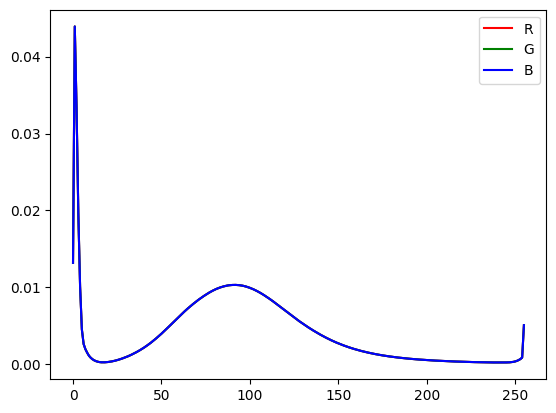

In [56]:
plt.plot(hist_r, label="R", color='r')
plt.plot(hist_g, label="G", color='g')
plt.plot(hist_b, label="B", color='b')
plt.legend()
plt.show()

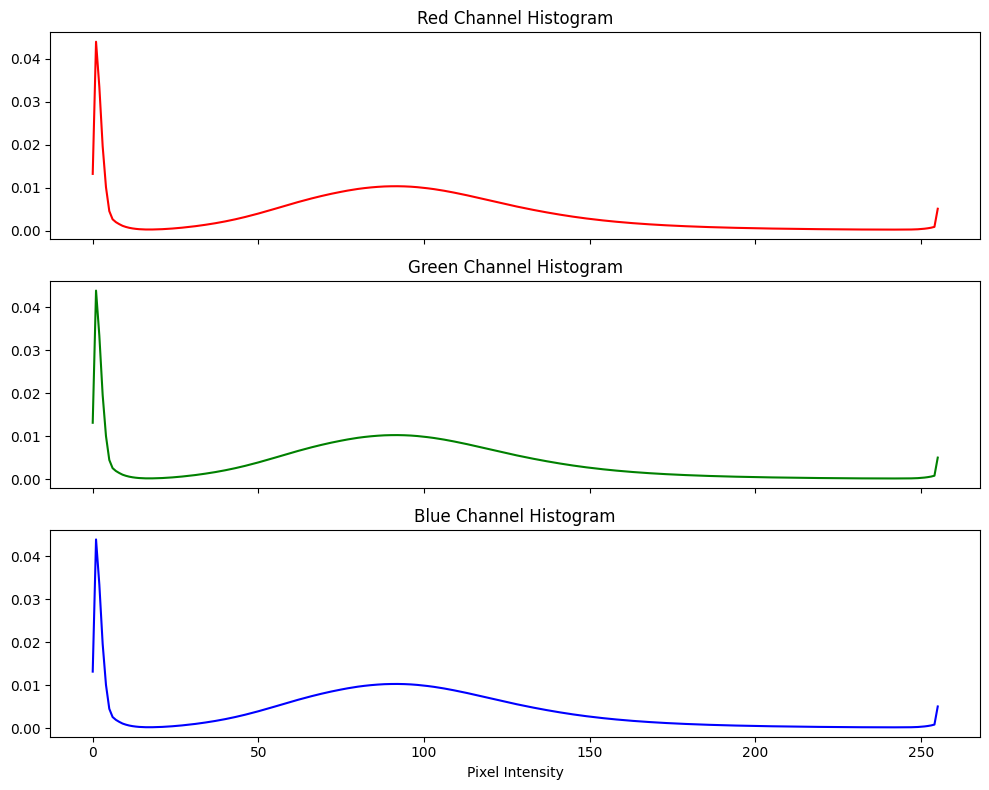

In [57]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(hist_r, color='r')
axs[0].set_title('Red Channel Histogram')
axs[1].plot(hist_g, color='g')
axs[1].set_title('Green Channel Histogram')
axs[2].plot(hist_b, color='b')
axs[2].set_title('Blue Channel Histogram')
plt.xlabel('Pixel Intensity')
plt.tight_layout()
plt.show()